此文件部分参考[这份笔记](https://www.kaggle.com/code/wangdark/classify-leaves-resnet/notebook)  
# 包导入和参数设置

In [1]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决画图时内核崩溃
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import os
from PIL import Image
import torchvision.models as models
from tqdm import tqdm 
from torch.utils.data import random_split

base_path = './classify-leaves'
out_path = './working'

# 数据查看

In [2]:
train_df= pd.read_csv(os.path.join(base_path,"train.csv"))
test_df = pd.read_csv(os.path.join(base_path,"test.csv"))

# 统计每个类别的数量
label_counts = train_df['label'].value_counts()

print(train_df.shape,'\n')
print(train_df.info(),'\n')
print(train_df.describe(), "\n")
print(train_df.head(),'\n')

(18353, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18353 entries, 0 to 18352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18353 non-null  object
 1   label   18353 non-null  object
dtypes: object(2)
memory usage: 286.9+ KB
None 

               image             label
count          18353             18353
unique         18353               176
top     images/0.jpg  maclura_pomifera
freq               1               353 

          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera 



# 饼状图

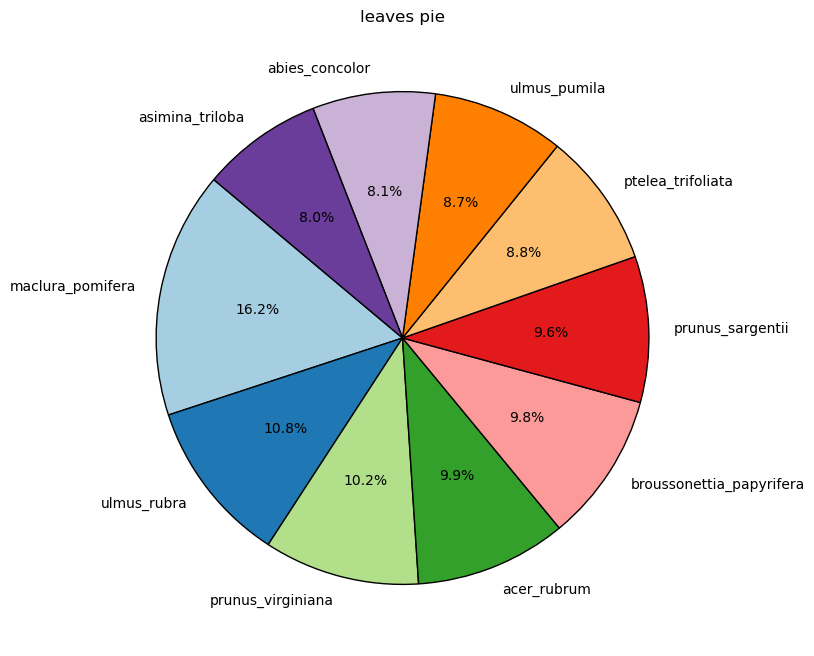

In [3]:
plt.figure(figsize=(8, 8)) 
plt.pie(
    label_counts.values[:10], 
    labels=label_counts.index[:10], 
    autopct='%1.1f%%',  # 显示百分比
    colors=plt.cm.Paired.colors,  # 配色
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}  # 添加边框
)

# 设置标题
plt.title("leaves pie")

# 显示图像
plt.show()

# 直方图

C:\Users\10702\AppData\Local\Temp\ipykernel_8168\2257238366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别


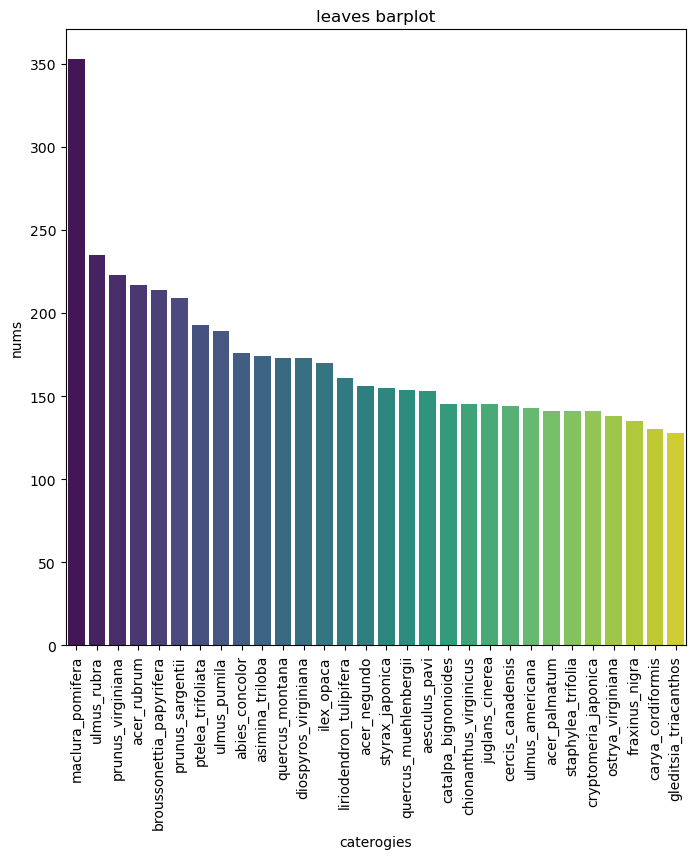

In [4]:
# 绘制直方图
plt.figure(figsize=(8, 8)) 
sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别
plt.xticks(rotation=90)  # 旋转x轴标签，防止重叠
plt.xlabel("caterogies")
plt.ylabel("nums")
plt.title("leaves barplot")

# 显示图像
plt.show()

# 预览图片

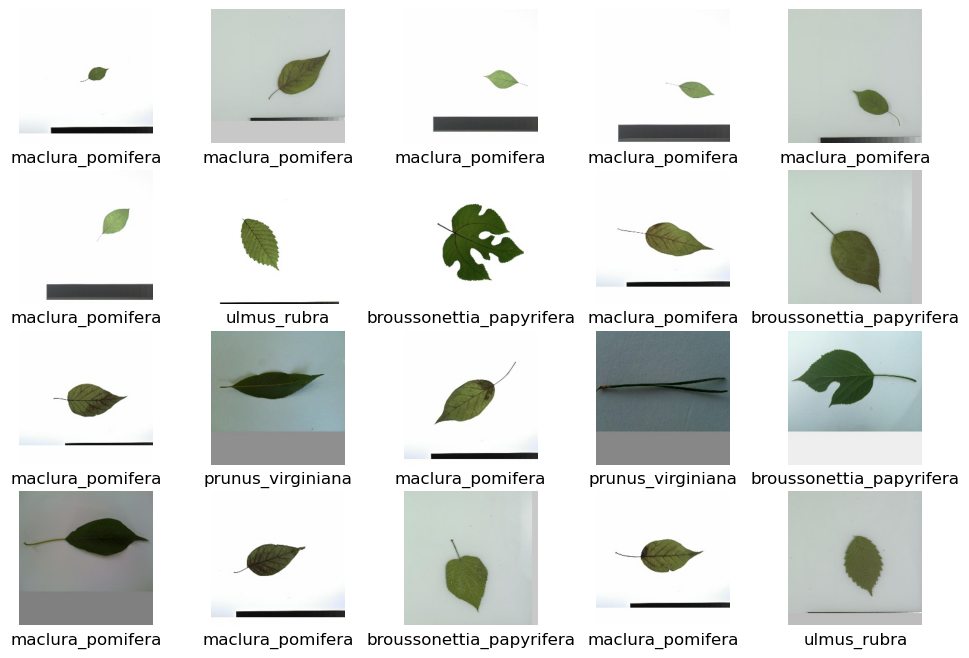

In [5]:
# 查看前20张图片
preview_image_paths = train_df['image'][:20]
preview_image_labels = train_df['label'][:20]
# 创建子图
fig, axes = plt.subplots(4,5, figsize=(12, 8))  # 一行多列

for i,(ax,img_path) in enumerate(zip(axes.flatten(),preview_image_paths)):
    img = mpimg.imread(os.path.join("./classify-leaves", img_path))  # 读取图片
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(preview_image_labels[i],y=-0.2)

plt.show()

# 准备数据

In [6]:
# 获取所有唯一的类别（叶子种类）
unique_labels = train_df["label"].unique()

# 创建 类别 → 索引 的映射
label2idx = {label: idx for idx, label in enumerate(unique_labels)}

# 创建反向映射（id → label）
idx2label = {v: k for k, v in label2idx.items()}

# 自定义dataset

In [7]:
class LeaveDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    #定义索引运算符
    def __getitem__(self, idx):
        img_path = os.path.join(base_path, self.data.iloc[idx,0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)  # 应用转换
        
        label_name = self.data.iloc[idx,1]
        label = label2idx[label_name]  # 转换为整数索引

        return image, label  # 返回 (图片, 标签)

# 封装DataLoader

In [8]:
batch_size=128

# 定义数据转换
transform = T.Compose([
    # T.Resize((224, 224)),  # 调整图片大小
    T.ToTensor(),  # 转为张量
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

train_dataset = LeaveDataset(train_df,transform)

# 计算拆分大小
total_size = len(train_dataset)
test_size = int(0.2 * total_size)  # 20% 作为测试集
train_size = total_size - test_size  # 剩下的作为训练集

# 随机拆分数据
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# 重新创建 DataLoader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=0)
# print(type(train_loader))
# for item in test_loader:
#     item0 = item[0]
#     item1 = item[1]
#     print(item0.shape)
#     print(item1[0])
#     # print(feature[0].shape)
#     # print(label)
#     print('-------')
#     break
# sys.exit(0)

# 定义模型

In [9]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X#这一行是残差网络包含之前的小网络的关键
        return F.relu(Y)
        
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
'''
num_residuals:重复使用block的数量
'''
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
'''
上面有b1到b5 5个stage
其中b1有1个block
b2到b5各有2个block
'''
resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 176))

# 损失函数和优化器

In [10]:
# 交叉熵损失（适用于分类问题）
criterion = nn.CrossEntropyLoss()

# 学习率，动量
lr,momentum = 0.01,0.9

# 训练模型

loss 0.062,train acc 0.984,test acc 0.244
346.3 examples/sec on cuda:0


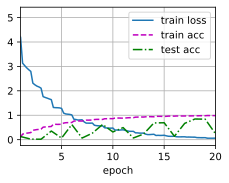

In [11]:
from IPython import display
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
def accuracy(y_hat, y):
    if y_hat.dim() > 1 and y_hat.size(1) > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.to(dtype=y.dtype) == y
    return float(cmp.sum().item())
    
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """
    使用GPU计算模型在数据集上的精度
    device决定了在cpu还是gpu上进行计算
    """
    if isinstance(net, torch.nn.Module):
        net.eval() # net.eval()开启验证模式，不计算梯度和更新梯度
        if not device:
            device = next(iter(net.parameters())).device # 看net.parameters()中第一个元素的device为哪里
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X,list):
            X = [x.to(device) for x in X] # 如果X是个List，则把每个元素都移到device上
        else:
            X = X.to(device) # 如果X是一个Tensor，则只用移动一次，直接把X移动到device上
        y = y.to(device)
        metric.add(accuracy(net(X),y),y.numel()) # y.numel() 为y元素个数 
    return metric[0]/metric[1]
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
    
import time
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU  参数`device`决定模型和数据是在cpu还是gpu上运行"""
    print('training on',device)
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # 根据输入、输出大小，使得随即初始化后，输入和输出的的方差是差不多的               
    net.apply(init_weights)#对每一层网络的parameter调用init_weights
    net.to(device)#将整个神经网络模型(包括所有参数和缓存)移动到device
    # optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,weight_decay=1e-4) #小批量随机梯度下降
    optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum) #小批量随机梯度下降
    loss = nn.CrossEntropyLoss() #softmax的基础上,再取对数再乘(-1/n)
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            
            if(i+1) % (num_batches//5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f},train acc {train_acc:.3f},'
         f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
         f' on {str(device)}')
    
train_ch6(resnet,train_loader,test_loader,20,lr,try_gpu())